# Applied Computational Statistics (ACS)

## SW3

Submit your answers <b>individually</b>.

Make sure to follow all the prescribed naming conventions set in the code below.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

atol = 1e-06
rtol = 1e-05

---

### MLE Exercise

#### Q1.

Implement a training loop in `PyTorch` that calculates the maximum likelihood estimates of the parameters of a Normal distribution ($\mu$ and $\sigma$) using the data in `mle_data.csv`.

For the assert:

1. $x$ should be a `torch.tensor` containing the data.

2. The final estimates for $\mu$ and $\sigma$ should be a scalar.

In [86]:
df = pd.read_csv('mle_data.csv')
df

,x
0,181.217268
1,69.412179
2,73.591412
3,46.351569
4,143.270381
...,...
995,94.177793
996,-13.864900
997,96.518773
998,117.693521


In [87]:
df['x'].std()

49.074750209128005

In [88]:
x = torch.tensor(df['x']).type(torch.FloatTensor)
x.requires_grad = True
# initialize guesses
mu = torch.tensor(200.0, requires_grad=True)
sigma = torch.tensor(20.0, requires_grad=True)


In [89]:
def neg_loglik_fn(x, mu, sigma):
    # YOUR CODE HERE
    normal_pdf = (
        (1 / torch.sqrt(2 * torch.tensor(np.pi) * (sigma**2)))
        * torch.exp(-0.5 * ((x-mu) / sigma)**2)
    )
    return -torch.sum(torch.log(normal_pdf))

    
lr = 0.1

for t in range(1000):
    neg_loglik = neg_loglik_fn(x, mu, sigma)
    neg_loglik.backward()
    
    if t%100 == 0:
        print(f'neg-loglik = {neg_loglik.data.numpy().round(2)}',
              f'mu = {mu.data.numpy().round(2)}',
              f'dL/dmu = {mu.grad.data.numpy().round(4)}',
              f'stdev = {sigma.data.numpy().round(2)}',
             f'dL/dstdev = {sigma.grad.data.numpy().round(4)}')
    mu.data -= lr * mu.grad.data
    sigma.data -= lr * sigma.grad.data
    
    mu.grad.data.zero_()
    sigma.grad.data.zero_()
    

mu = mu.data.numpy()
sigma = sigma.data.numpy()

neg-loglik = 18941.619140625 mu = 200.0 dL/dmu = 245.14840698242188 stdev = 20.0 dL/dstdev = -1452.695556640625
neg-loglik = 5834.14013671875 mu = 146.22000122070312 dL/dmu = 3.297300100326538 stdev = 115.88999938964844 dL/dstdev = 5.823200225830078
neg-loglik = 5338.3798828125 mu = 110.70999908447266 dL/dmu = 2.8447000980377197 stdev = 55.5099983215332 dL/dstdev = 3.5009000301361084
neg-loglik = 5311.7900390625 mu = 102.08999633789062 dL/dmu = 0.061500001698732376 stdev = 49.04999923706055 dL/dstdev = 0.0027000000700354576
neg-loglik = 5311.77978515625 mu = 101.94000244140625 dL/dmu = 0.0008999999845400453 stdev = 49.04999923706055 dL/dstdev = 0.0
neg-loglik = 5311.77978515625 mu = 101.94000244140625 dL/dmu = 0.0 stdev = 49.04999923706055 dL/dstdev = 0.0
neg-loglik = 5311.77978515625 mu = 101.94000244140625 dL/dmu = 0.0 stdev = 49.04999923706055 dL/dstdev = 0.0
neg-loglik = 5311.77978515625 mu = 101.94000244140625 dL/dmu = 0.0 stdev = 49.04999923706055 dL/dstdev = 0.0
neg-loglik = 531

In [90]:
assert np.isclose(mu, torch.mean(x).data.numpy())

In [91]:
# Hidden Test

---

### Cross-Validation Exercise

#### Q1.

Using the training data in `cv_train.csv`, use 10-Fold CV (with `random_state=1`) to select the best $k$ (from $1$ to $50$) in a k-NN regression model.

For the scoring criterion, use the <b>root mean square error</b>,

\begin{align*}
    \text{RMSE} &= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
\end{align*}

Store the best $k$ in `k_optim`.

In [92]:
df = pd.read_csv('cv_train.csv')
df

,x,y
0,4.438178,235.403163
1,4.991009,28.536899
2,-3.383234,-20.244820
3,-13.455054,413.908490
4,-5.329361,166.088298
...,...,...
8995,2.515027,159.444066
8996,-10.034567,235.769378
8997,0.890880,108.278526
8998,2.139057,-14.263007


In [93]:
x = df['x'].to_numpy().reshape(-1,1)
y = df['y']


rmse_all = {}

k_grid  = range(1, 51)
kf = KFold(n_splits = 10, random_state=1, shuffle=True)

rmse_test_knn_all = []


for k in k_grid:
    rmse_train_knn = []
    rmse_test_knn = []
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train)
        
        fitted = model.predict(x_train)
        y_hat = model.predict(x_test)
        
        # squared = False or get the square root of mean_squared_error
        # without the squared parameter
        rmse_train_knn.append(mean_squared_error(y_train,fitted, squared=False))
        rmse_test_knn.append(mean_squared_error(y_test, y_hat, squared=False))
        
    rmse_train_knn = np.array([rmse_train_knn])
    rmse_test_knn = np.array([rmse_test_knn])
    
    print(f'k = {k} -- Avg. Test RMSE = {rmse_test_knn.mean()}')
    rmse_test_knn_all.append(rmse_test_knn)
    rmse_all[k] = rmse_test_knn.mean()

# YOUR CODE HERE


k = 1 -- Avg. Test RMSE = 142.18603746648506
k = 2 -- Avg. Test RMSE = 123.59690241213293
k = 3 -- Avg. Test RMSE = 116.34334519321006
k = 4 -- Avg. Test RMSE = 113.2315525393014
k = 5 -- Avg. Test RMSE = 110.70578927826114
k = 6 -- Avg. Test RMSE = 109.34831945801292
k = 7 -- Avg. Test RMSE = 108.12233525934967
k = 8 -- Avg. Test RMSE = 107.30173721699514
k = 9 -- Avg. Test RMSE = 106.94768459528734
k = 10 -- Avg. Test RMSE = 106.44848502025529
k = 11 -- Avg. Test RMSE = 106.03310593585365
k = 12 -- Avg. Test RMSE = 105.80394818052096
k = 13 -- Avg. Test RMSE = 105.58954065008695
k = 14 -- Avg. Test RMSE = 105.41722589855556
k = 15 -- Avg. Test RMSE = 105.34232488166774
k = 16 -- Avg. Test RMSE = 105.22920427953326
k = 17 -- Avg. Test RMSE = 105.26825220324118
k = 18 -- Avg. Test RMSE = 105.0443642197504
k = 19 -- Avg. Test RMSE = 104.99052786356961
k = 20 -- Avg. Test RMSE = 104.9217558731996
k = 21 -- Avg. Test RMSE = 104.82958674098602
k = 22 -- Avg. Test RMSE = 104.76530442776713


In [94]:
k_optim = pd.Series(rmse_all).idxmin()
k_optim, pd.Series(rmse_all).min()

(29, 104.65346054070149)

In [95]:
assert k_optim == 29

---

### Bootstrap Exercise

#### Q1.

Using optimal $k$ solved in the last section, fit a k-NN model to the training data `cv_train.csv` and calculate the RMSE on the test data in `cv_test.csv`.

In [96]:
df_train = pd.read_csv('cv_train.csv')
df_test = pd.read_csv('cv_test.csv')

In [97]:
print('    ----df_train----', end='')
display(df_train)
print('    ----df_test----', end='')
display(df_test)

    ----df_train----

,x,y
0,4.438178,235.403163
1,4.991009,28.536899
2,-3.383234,-20.244820
3,-13.455054,413.908490
4,-5.329361,166.088298
...,...,...
8995,2.515027,159.444066
8996,-10.034567,235.769378
8997,0.890880,108.278526
8998,2.139057,-14.263007


    ----df_test----

,x,y
0,1.384249,-28.158847
1,2.357853,20.767435
2,-4.183601,-164.479264
3,2.365556,190.545763
4,-5.110197,-106.221617
...,...,...
995,1.568204,23.707379
996,0.074237,62.037567
997,6.079593,104.595255
998,-0.852969,8.987755


In [98]:
x_train = df_train['x'].to_numpy().reshape(-1, 1)
y_train = df_train['y']
x_test = df_test['x'].to_numpy().reshape(-1, 1)
y_test = df_test['y']

rmse_train_knn = []
rmse_test_knn = []

model = KNeighborsRegressor(n_neighbors=k_optim).fit(x_train, y_train)
fitted = model.predict(x_train)
y_hat = model.predict(x_test)

rmse_train_knn.append(mean_squared_error(y_train, fitted, squared=False))
rmse_test_knn.append(mean_squared_error(y_test, y_hat, squared=False))

rmse_train_knn = np.array(rmse_train_knn)
rmse_test_knn = np.array(rmse_test_knn)



rmse_test = rmse_test_knn.mean()
rmse_test

102.00535713349203

In [99]:
assert np.isclose(rmse_test, 102.00535713349203)

#### Q2.

Using bootstrap, calculate the 95% prediction interval (orange shade) and plot it against the test set and your model's predictions (red line).

For the assert, place your 95% lower and upper bounds in `pi_95`. It will check the first column which should contain the 95% lower bound and upper bound for the prediction when $x = -23.288090752195814$.

Run enough simulations to meet the tolerance defined by the assert.

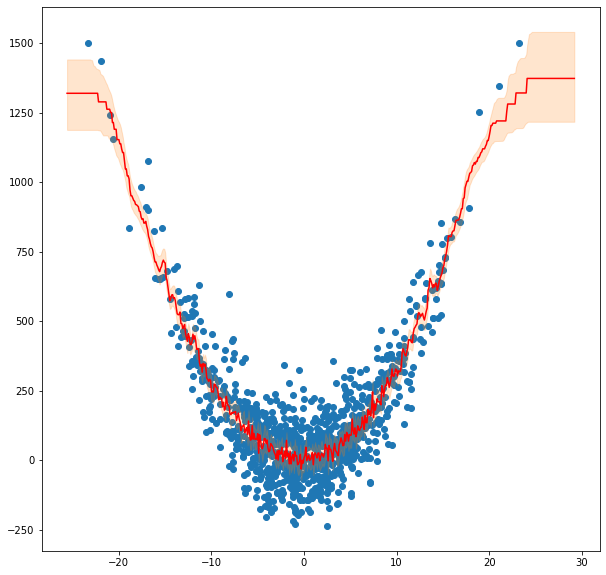

In [105]:
# YOUR CODE HERE

x_train = df_train['x'].to_numpy().reshape(-1, 1)
y_train = df_train['y']
x_test = df_test['x'].to_numpy().reshape(-1, 1)
y_test = df_test['y']

model = KNeighborsRegressor(n_neighbors=k_optim).fit(x_train, y_train)

n = x_train.shape[0]

x_range = np.arange(x_train.min(), x_train.max()+0.1, 0.1).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x_test, y_test)
plt.plot(x_range, model.predict(x_range), color='r')

sim_size = 3400

pred_vec = []

for i in range(sim_size):
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    x_boot = x_train[samp_ind].reshape(-1, 1)
    y_boot = y_train[samp_ind]
    
    
    model = KNeighborsRegressor(n_neighbors=k_optim).fit(x_boot, y_boot)
    pred_vec.append(model.predict(x_range))
    
pred_vec = np.array(pred_vec)
pi_95 = np.nanquantile(pred_vec, q=[0.025, 0.975], axis=0)
ax.fill_between(x_range.flatten(), pi_95[0, :], pi_95[1, :], color='tab:orange', alpha=0.2)




plt.show()


In [101]:
pi_95

array([[1190.38606591, 1190.38606591, 1190.38606591, ..., 1216.57265668,
        1216.57265668, 1216.57265668],
       [1445.02158584, 1445.02158584, 1445.02158584, ..., 1536.13757064,
        1536.13757064, 1536.13757064]])

In [102]:
# 95% PI lower and upper bound for the prediction when x = -23.288090752195814
# Each bound must be between these values (which are themselves estimates of 99%-ile bounds of these statistics!)
assert 1175.41252481 <= pi_95[0, 0] <= 1196.5568916
assert 1434.3119279 <= pi_95[1, 0] <= 1457.71248042

Very cool. :)